<a href="https://colab.research.google.com/github/amien1410/colab-notebooks/blob/main/Colab_Pyspark_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Install Kaggle modules and download the dataset

from google.colab import drive
drive.mount('/content/drive')

!pip install kaggle
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'
!kaggle competitions download -c digit-recognizer
!unzip -q "/content/digit-recognizer.zip"

Mounted at /content/drive
  0% 0.00/15.3M [00:00<?, ?B/s]
100% 15.3M/15.3M [00:00<00:00, 433MB/s]


In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, monotonically_increasing_id
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.classification import MultilayerPerceptronClassifier, MultilayerPerceptronClassificationModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

# 1. Start Spark session
spark = SparkSession.builder.appName("MNIST_Neural_Network").getOrCreate()

# 2. Load training data
train_df = spark.read.csv("/content/train.csv", header=True, inferSchema=True)

# 3. Assemble features
pixel_cols = [f"pixel{i}" for i in range(784)]
assembler = VectorAssembler(inputCols=pixel_cols, outputCol="features_raw")
train_df = assembler.transform(train_df)

# 4. Normalize features (0–1)
scaler = MinMaxScaler(inputCol="features_raw", outputCol="features")
scaler_model = scaler.fit(train_df)
scaled_train_df = scaler_model.transform(train_df).select("label", "features")

# 5. Train-test split
train_data, test_data = scaled_train_df.randomSplit([0.8, 0.2], seed=42)

# 6. Define neural network layers
layers = [784, 128, 64, 10]  # input → hidden1 → hidden2 → output (10 classes)

# 7. Train neural network model
mlp = MultilayerPerceptronClassifier(labelCol="label", featuresCol="features", maxIter=100, layers=layers, blockSize=128, seed=123)
mlp_model = mlp.fit(train_data)

# 8. Evaluate accuracy
predictions = mlp_model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"✅ Test Accuracy: {accuracy:.4f}")

# 9. Confusion matrix
pred_rdd = predictions.select("prediction", "label").rdd.map(lambda row: (float(row[0]), float(row[1])))
metrics = MulticlassMetrics(pred_rdd)
print("\n📊 Confusion Matrix:")
print(metrics.confusionMatrix().toArray())

# 10. Save the model
mlp_model.write().overwrite().save("mlp_mnist_model")
print("💾 Model saved as: mlp_mnist_model")

# 11. Load test data
test_df = spark.read.csv("/content/test.csv", header=True, inferSchema=True)

# 12. Assemble and scale test features
test_df = assembler.transform(test_df)
test_scaled = scaler_model.transform(test_df).select("features")

# 13. Load model and predict test labels
loaded_model = MultilayerPerceptronClassificationModel.load("mlp_mnist_model")
test_predictions = loaded_model.transform(test_scaled).select("prediction")

# 14. Add ImageId for submission
test_predictions = test_predictions.withColumn("ImageId", monotonically_increasing_id() + 1)
submission = test_predictions.selectExpr("ImageId", "int(prediction) as Label")

# 15. Export submission file
submission.coalesce(1).write.csv("submission", header=True, mode="overwrite")
print("📤 Submission saved to ./submission/")

✅ Test Accuracy: 0.9653


/usr/local/lib/python3.11/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(



📊 Confusion Matrix:
[[763.   0.   0.   0.   0.   1.   6.   0.   3.   1.]
 [  0. 918.   2.   0.   1.   1.   2.   3.   5.   0.]
 [  1.   3. 772.   5.   6.   2.   4.   7.   4.   3.]
 [  3.   0.  17. 808.   1.  18.   1.   5.  10.   8.]
 [  0.   0.   2.   0. 756.   3.   1.   1.   2.  18.]
 [  4.   0.   1.   8.   2. 746.   7.   0.   9.   3.]
 [  1.   1.   2.   1.   2.   3. 803.   1.   2.   0.]
 [  3.   2.   9.   3.   3.   0.   0. 818.   1.   7.]
 [  0.   1.   5.   3.   1.   6.   4.   2. 804.   4.]
 [  5.   0.   4.   5.  14.   2.   0.   3.   4. 814.]]
💾 Model saved as: mlp_mnist_model
📤 Submission saved to ./submission/


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


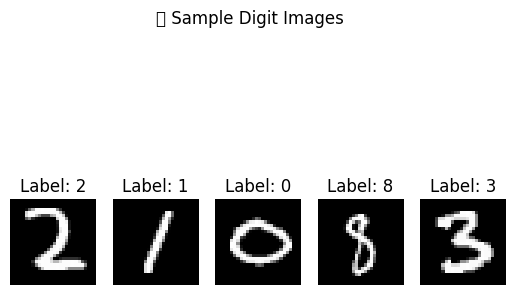

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import rand

# Sample and visualize 5 random digits
sample_images = train_df.select("label", *pixel_cols).orderBy(rand()).limit(5).toPandas()

for i in range(5):
    pixels = sample_images.iloc[i, 1:].values.reshape(28, 28)
    label = sample_images.iloc[i, 0]
    plt.subplot(1, 5, i+1)
    plt.imshow(pixels, cmap="gray")
    plt.axis('off')
    plt.title(f"Label: {label}")

plt.suptitle("📊 Sample Digit Images")
plt.show()